In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")
import os

In [27]:
station_id=5001
# read the .csv file into a DataFrame
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
df=pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['acquisition_timestamp'], utc=True)


# rearrange the data
new_data = df.pivot_table(index='timestamp', columns='parameter_type', values='value').reset_index()

# ensure 'acquisition_timestamp' is in datetime format
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])

new_data.set_index('timestamp', inplace=True)


# fill NaN values in the row with the values of next row with non NaN values
new_data = new_data.fillna(method='bfill')


print('Shape of data :', new_data.shape)
print('index type :',type(new_data.index))
new_data.head()


Shape of data : (271508, 7)
index type : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


parameter_type,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
timestamp,,,,,,,
2020-10-13 10:20:00+00:00,952.8,7.4,0.0,63.9,285.6,294.0,2.45
2020-10-13 10:25:00+00:00,952.8,7.5,0.0,62.5,262.0,294.0,2.45
2020-10-13 10:30:00+00:00,952.8,7.4,0.0,61.9,270.9,282.0,2.81
2020-10-13 10:35:00+00:00,952.8,7.5,0.0,62.2,307.4,301.0,3.28
2020-10-13 10:40:00+00:00,952.8,7.6,0.0,62.2,342.0,289.0,1.27


In [28]:
# count the NaN values
nan_count = new_data.isna().sum()
print(nan_count)
# NO nan values

parameter_type
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64


In [29]:
# check for missing measurements (skipped times)
complete_range = pd.date_range(start=new_data.index.min(), end=new_data.index.max(), freq='5T')
missing_timestamps = complete_range.difference(new_data.index)
print(f"missing time stamps ={len(missing_timestamps)}")
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
print(f"df complete range = {len(df_complete_range)}")

missing time stamps =5112
df complete range = 276620


In [30]:
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
new_data_incomplete = df_complete_range.merge(new_data, left_index=True, right_index=True, how='left')
# print(wind_speed_incomplete)
print(new_data_incomplete.isna().sum()) # okay

# missing measurements are filled with the next available measurement
new_data_all = new_data_incomplete.bfill()

# fill NaN values in the row with the values of next row with non-NaN values
new_data_all = new_data_all.fillna(method='bfill')

#print(new_data_all)
print(new_data_all.isna().sum()) # okay

str(new_data_all.index.dtype) # okay

AIR_PRESSURE                 5112
AMBIENT_TEMPERATURE          5112
RAIN_INTENSITY               5112
RELATIVE_HUMIDITY            5112
SOLAR_RADIATION_INTENSITY    5112
WIND_DIRECTION               5112
WIND_SPEED                   5112
dtype: int64
AIR_PRESSURE                 0
AMBIENT_TEMPERATURE          0
RAIN_INTENSITY               0
RELATIVE_HUMIDITY            0
SOLAR_RADIATION_INTENSITY    0
WIND_DIRECTION               0
WIND_SPEED                   0
dtype: int64


'datetime64[ns, UTC]'

In [19]:
# resampled the data hourly with mean.
new_data_all_resampled=new_data_all.resample('1H').mean()
new_data_all_resampled.head()

,AIR_PRESSURE,AMBIENT_TEMPERATURE,RAIN_INTENSITY,RELATIVE_HUMIDITY,SOLAR_RADIATION_INTENSITY,WIND_DIRECTION,WIND_SPEED
2020-10-13 10:00:00+00:00,952.762500,7.687500,0.0,61.675000,300.837500,293.625000,2.357500
2020-10-13 11:00:00+00:00,952.366667,8.958333,0.0,56.825000,258.341667,312.666667,1.675000
2020-10-13 12:00:00+00:00,951.783333,10.183333,0.0,48.391667,260.816667,270.833333,0.826667
2020-10-13 13:00:00+00:00,951.691667,10.716667,0.0,43.625000,161.950000,291.083333,0.460833
2020-10-13 14:00:00+00:00,951.508333,10.833333,0.0,44.483333,155.100000,280.416667,0.477500


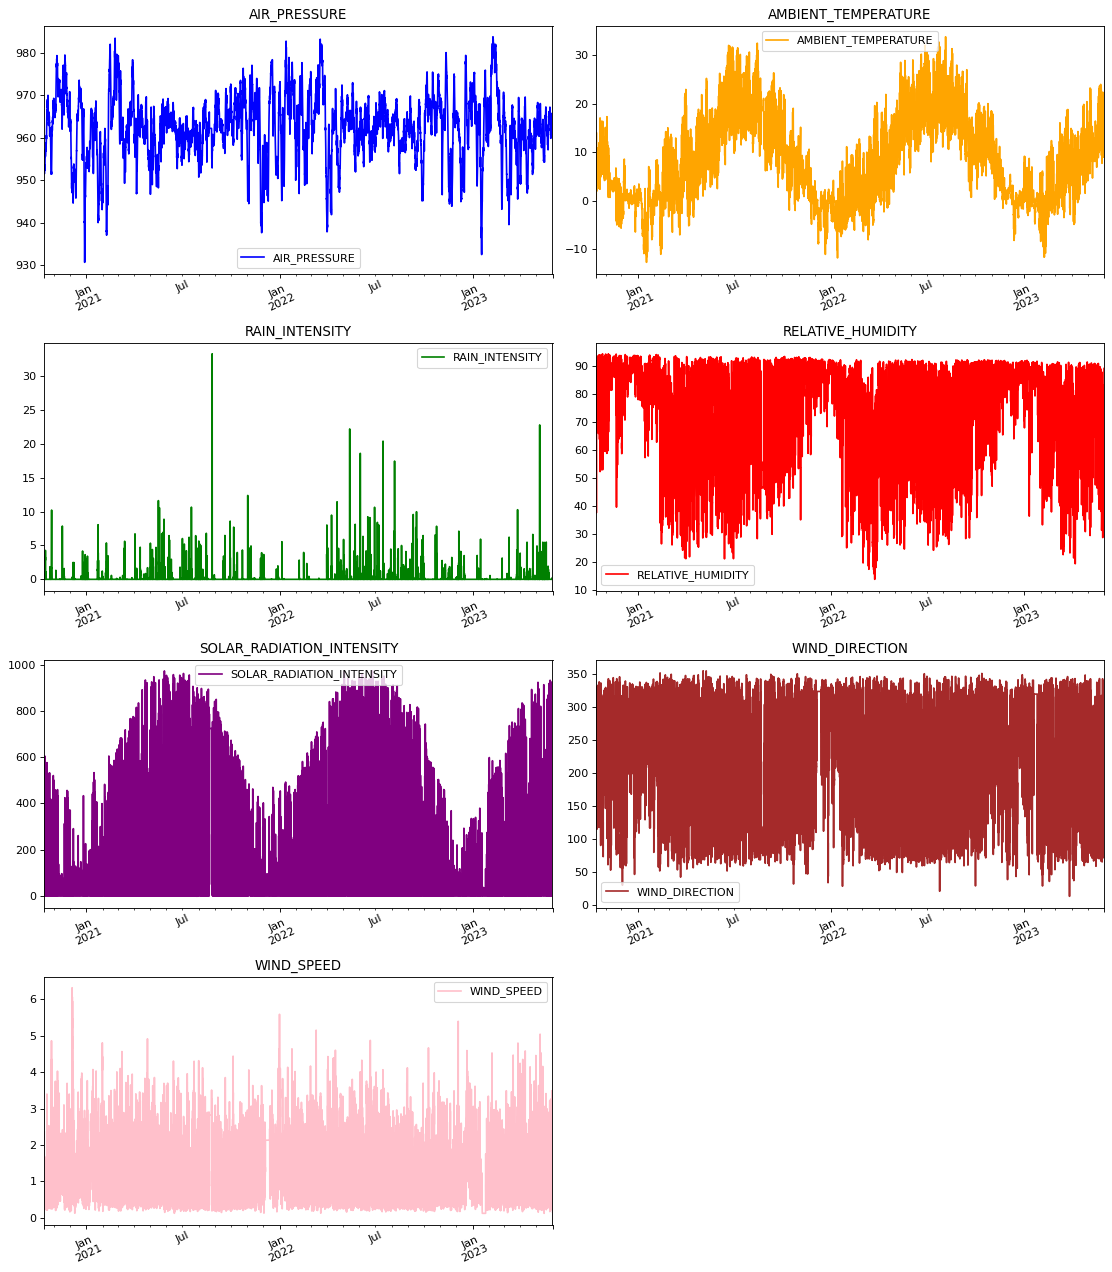

In [24]:
#  having some problems visualizing the data -----------  Problem solved later

color_list=["blue","orange","green","red","purple","brown","pink"]

def Visualize(data):
    features=list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)


   # create subplots with a flexible number of rows
    nrows = int(np.ceil(feature_size / 2))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, 
        figsize=(14, nrows*4), dpi=80, facecolor='w', edgecolor='k'
    )
    
     # flatten the axes array for easy indexing
    if feature_size == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()


    # plot each feature
    for i in range(feature_size):
     key = features[i]
     c = color_list[i%(len(color_list))]
     t_data=data[key]
    
     ax=t_data.plot(
        ax=axes[i],
        color=c,
        title=key,
        rot=25,
     )
     ax.legend([key])
    

     # hide any unused subplots
    for j in range(feature_size, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()    

Visualize(new_data_all_resampled)    

In [14]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


In [26]:
# AD Fuller Test on the data

for i in range(len(new_data_all_resampled.columns)):
    result = adfuller(new_data_all_resampled[new_data_all_resampled.columns[i]])

    if result[1]<=0.05:
        print('{}-Series is stationary'.format(new_data_all_resampled.columns[i]))
    else : 
        print('{}-Series is not stationary'.format(new_data_all_resampled.columns[i]))

AIR_PRESSURE-Series is stationary
AMBIENT_TEMPERATURE-Series is stationary
RAIN_INTENSITY-Series is stationary
RELATIVE_HUMIDITY-Series is stationary
SOLAR_RADIATION_INTENSITY-Series is stationary
WIND_DIRECTION-Series is stationary
WIND_SPEED-Series is stationary


In [21]:

# Do the granger casuality tests - for this test you have to visually see the data and use some common sense to figure out which parameters would depend...
# ...on which other parameters and which parameters wont. For example air pressure would not be dependent on solar radiation intensity. But ambient...
#... temperatue would be dependent on the solar radiation intensity. similarly wind direction would not be dependent on wind speed. But relative humidity...
# ... would be dependent on rain intensity. To figure out dependency of parameters this casuality test is done by passing parameters to the test function...

# maybe all parameters are a little bit dependent on each other - dont assume anything
max_lags=8
y='AMBIENT_TEMPERATURE'

In [22]:
for i in range(len(new_data_all_resampled.columns)-1):
    results=grangercausalitytests(new_data_all_resampled[[y,]])

TypeError: grangercausalitytests() missing 1 required positional argument: 'maxlag'